## Setup

In [2]:
from datetime import datetime
import os, importlib

from functools import partial

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

crop_shape = (64, 64, 1)
image_shape = crop_shape

params = {
        'threshold_abs': 0.2, #seed pixel magnitude 
        'min_distance' : 0,   #minimal distance between roi seeds
        'roi_size_thr': 10    #minimal number of pixels in roi (patch)
        }

print('TensorFlow version: %s' % tf.__version__)

TensorFlow version: 2.5.0


## Use mixed precision policy: 32 bits for data, 16 bits for weights to profit from TensorCores
The mixed precision makes the trainign unstable - after some time loss goes to NAN.

In [ ]:
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'

## TF 2.4.1 with CUDA 11 requires setting the memor growth to True 

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


## Start the Tensorboard server. It is more convenient to open it in a new browser tab with 
[http://localhost:8008/](http://localhost:8008/)

In [ ]:
%%capture
%load_ext tensorboard
%tensorboard --logdir logs/fit --port=8008 --bind_all

## Test data manipulation functions 

In [ ]:
import io_functions as iof
importlib.reload(iof)

import plotting_functions as plf
importlib.reload(plf)

fileNames = ["UVWProjections_2018-06-19T15:13:33.941_0008.tfrecords"]
dataset = iof.readTFRecordFile(fileNames)
dataset = dataset.map(lambda item: iof.preprocessProjections(item, projection=0))

for data in dataset.take(1):
    rois = iof.find_ROIs(data, **params)
    if not len(rois):
        continue
    cropped, mask = iof.crop_ROI(data, rois[0], shape=(64,64))  
    plf.plotOriginal_vs_cropped(data, cropped, mask, rois[0])
    mask = tf.reshape(mask, (1,)+mask.shape)
    plf.plotOriginal_vs_decoded(mask, vae, threshold=0.2)
    
      
shapes_dataset = tf.data.Dataset.from_generator(iof.shapes_images_generator, (tf.bool))  
shapes_dataset = shapes_dataset.batch(1)
for data in shapes_dataset.take(1):
    plf.plotOriginal_vs_decoded(data, vae, threshold=0.2)
        
generator = partial(iof.cropped_images_generator, dataset, **params)  
cropped_dataset = tf.data.Dataset.from_generator(generator, (tf.float32))  
cropped_dataset = cropped_dataset.batch(1)
for data in cropped_dataset.take(1):
    plf.plotOriginal_vs_decoded(data, vae, threshold=0.2)

## Build the encoder, bottleneck and decoder Keras models

In [ ]:
#########################
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])
#########################
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim), dtype=tf.dtypes.float32)
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
#########################   
def getEncoder(filters, fc_size, latent_dim):
    encoder_inputs = keras.Input(shape=image_shape)
    x = encoder_inputs
    #x = data_augmentation(encoder_inputs)

    for nFilters in filters:
        x = layers.Conv2D(filters=nFilters, kernel_size=2, activation="relu", strides=2, padding="same")(x)

    endcoder_outputs = x 
    x = layers.Flatten()(x)
    x = layers.Dense(fc_size, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    
    print("Encoder input shape:",encoder_inputs.shape)
    print("Encoder output shape:",endcoder_outputs.shape)
    print("Latent dimension:",z.shape)
    return encoder, endcoder_outputs.shape[1:]
########################
########################
def getDecoder(filters, fc_size, latent_dim, encoder_shape):
    decoder_inputs = keras.Input(shape=(latent_dim))
    x = layers.Dense(np.prod(encoder_shape), activation="relu")(decoder_inputs)
    x = layers.Reshape(encoder_shape)(x)
    for nFilters in np.flip(filters, axis=[0]):
        x = layers.Conv2DTranspose(filters=nFilters, kernel_size=2, activation="relu", strides=2, padding="same")(x)

    decoder_outputs = layers.Conv2D(filters=1, kernel_size=1, activation="sigmoid", strides=1, padding="same")(x)
    decoder = keras.Model(decoder_inputs, decoder_outputs, name="decoder")
    print("Decoder output shape:",decoder_outputs.shape)
    return decoder
########################
########################  

## Test endocer/decoder creation

In [ ]:
latent_dim = 2
fc_size = 256
filters = np.array([32, 32, 64, 64])
encoder, encoder_shape = getEncoder(filters, fc_size, latent_dim)
decoder = getDecoder(np.flip(filters, axis=[0]), fc_size, latent_dim, encoder_shape)

print("output shape",encoder.get_layer(index=-1).output_shape[1])

tf.keras.utils.plot_model(encoder, 'fig_png/encoder_arch.png', show_shapes=True)
tf.keras.utils.plot_model(decoder, 'fig_png/decoder_arch.png', show_shapes=True)

## Define the VAE as a `Model` with a custom `train_step`. Encoder and decoder are parameters of the `Model`.

In [4]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, beta, **kwargs):
        super(VAE, self).__init__(**kwargs)
        
        for key, value in kwargs.items():
            print("{0} = {1}".format(key, value))
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        self.latent_dim = decoder.get_layer(index=-1).output_shape[1] 
        self.latent_var_names = ["z"+str(index) for index in range(0, self.latent_dim)]
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def evaluation(self, data, threshold):
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z_mean)
        binary_loss = keras.losses.BinaryCrossentropy()(data, reconstruction)
        
        reconstruction = tf.greater(reconstruction, tf.constant(threshold, dtype=tf.float32))
        reconstruction = tf.cast(reconstruction, dtype=tf.float32)
        mae_loss = tf.keras.losses.MeanAbsoluteError()(data, reconstruction)
        
        patchSize = tf.math.count_nonzero(data, dtype=tf.dtypes.float32)
        imageSize = tf.size(data)
        imageSize = tf.cast(imageSize, dtype=tf.dtypes.float32)
        normToPatchSize = tf.math.divide_no_nan(imageSize, patchSize)
        normToPatchSize = tf.where(normToPatchSize>0,normToPatchSize,0.0)
        binary_loss *= normToPatchSize
        mae_loss *= normToPatchSize
        
        binary_loss = tf.where(normToPatchSize>1,binary_loss,-1.0)
        mae_loss = tf.where(normToPatchSize>1,mae_loss,-1.0)
        
        z = dict(zip(self.latent_var_names,z_mean[0].numpy()))
        loss = {"binary_loss": binary_loss.numpy(),
                "mae_loss":mae_loss.numpy()
               }
        return {**z, **loss}

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            #reconstruction_loss = keras.losses.BinaryCrossentropy()(data, reconstruction)
            
            patchSize = tf.math.count_nonzero(data, axis=(1,2,3), dtype=tf.dtypes.float32)
            patchSize = tf.reshape(patchSize, shape=(-1,1,1,1))
            data = tf.cast(data, dtype=tf.dtypes.float32)
            data = tf.math.divide_no_nan(data, patchSize/4096.0)
            reconstruction_loss = keras.losses.MeanAbsoluteError()(data, reconstruction)
            
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = self.beta*tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
########################  

## Train the VAE
Notes:
* data.cache() provides significant speed up for the dataset from generator

In [ ]:
%%time
import io_functions as iof
importlib.reload(iof)

generator = iof.shapes_images_generator
dataset = tf.data.Dataset.from_generator(generator, output_signature=(tf.TensorSpec(shape=crop_shape, dtype=tf.bool)))
dataset = dataset.batch(32)
dataset = dataset.cache()

latent_dim = 10
fc_size = 256
filters = np.array([32, 32, 64, 64])
encoder, encoder_shape = getEncoder(filters, fc_size, latent_dim)
decoder = getDecoder(filters, fc_size, latent_dim, encoder_shape)
beta = 0.2*latent_dim/np.prod(encoder_shape)
vae = VAE(encoder, decoder, beta)

initial_learning_rate = 1E-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                                                            decay_steps=2000,
                                                            decay_rate=0.95,
                                                            staircase=True)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule))

log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=(2,10))

current_time = datetime.now().strftime("%b %d %Y %H:%M:%S")
print("Training start. Current Time =", current_time)

nEpochs = 10
vae.fit(dataset, epochs=nEpochs,
        verbose=1,  
        use_multiprocessing=True,   
        callbacks=[tensorboard_callback]
        )

current_time = datetime.now().strftime("%b %d %Y %H:%M:%S")
tag = "{epoch:04d}_"+datetime.now().strftime("%b_%d_%Y_%H_%M")
iof.saveVAE(vae, tag.format(epoch=nEpochs))
print("Training end. Current Time =", current_time)

## Display original and decoded images from fake dataset

CPU times: user 20.4 s, sys: 487 ms, total: 20.9 s
Wall time: 19 s


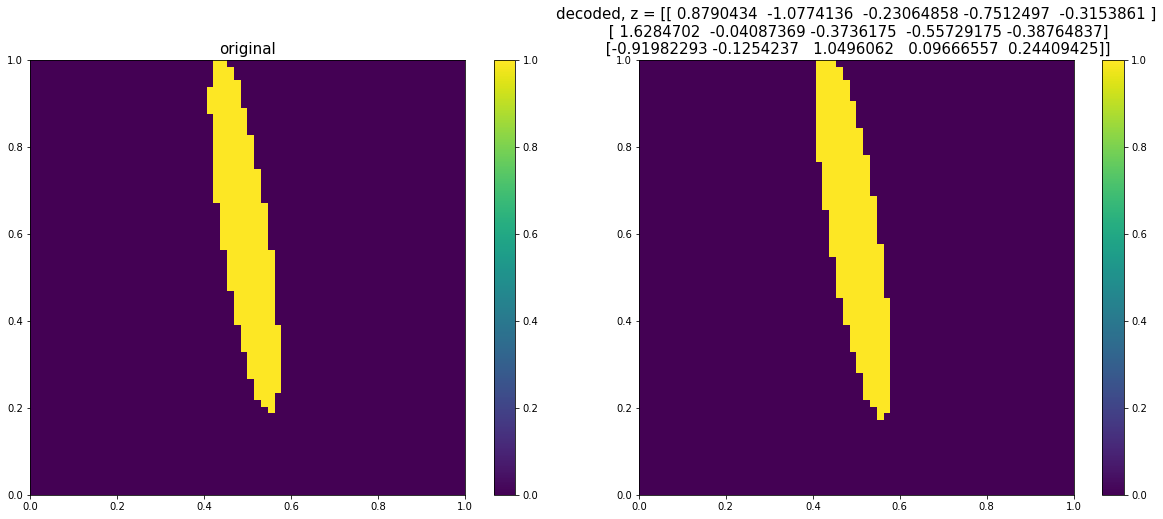

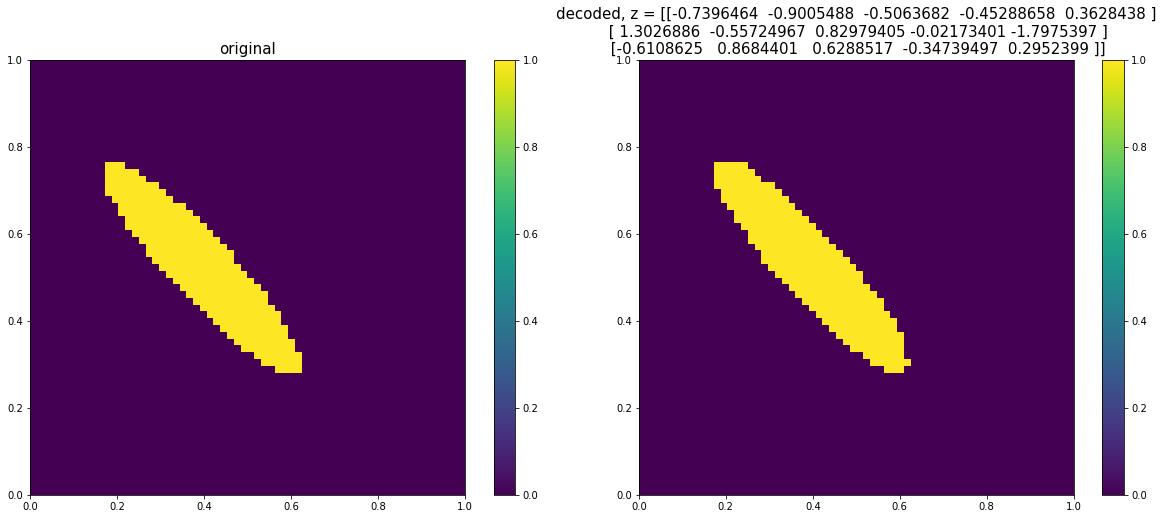

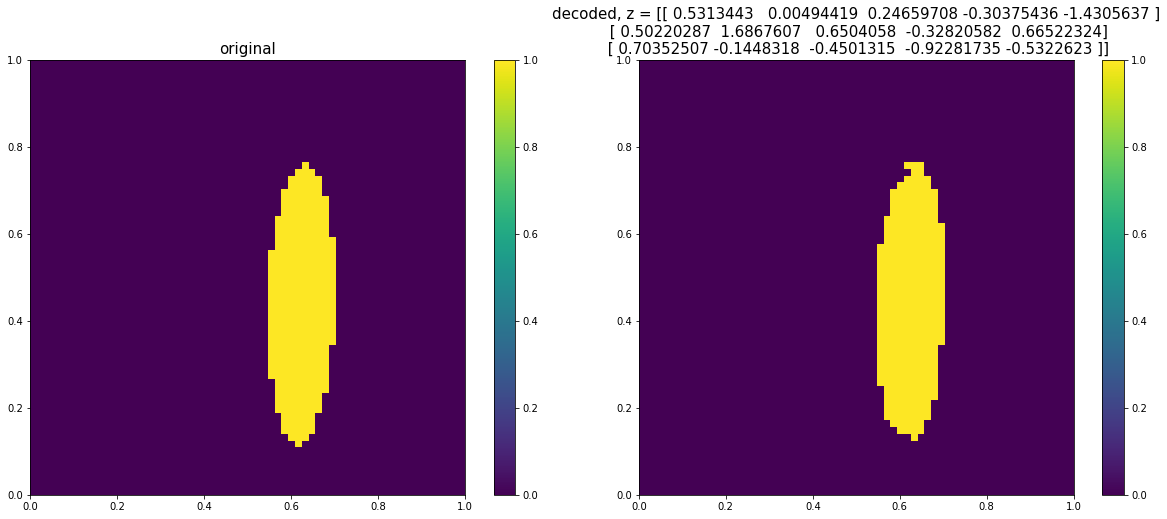

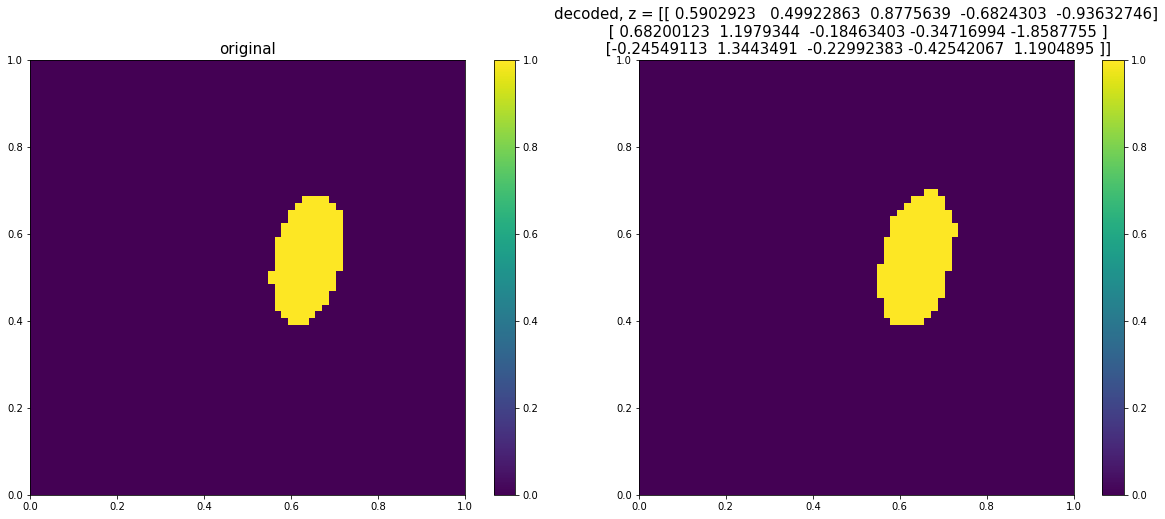

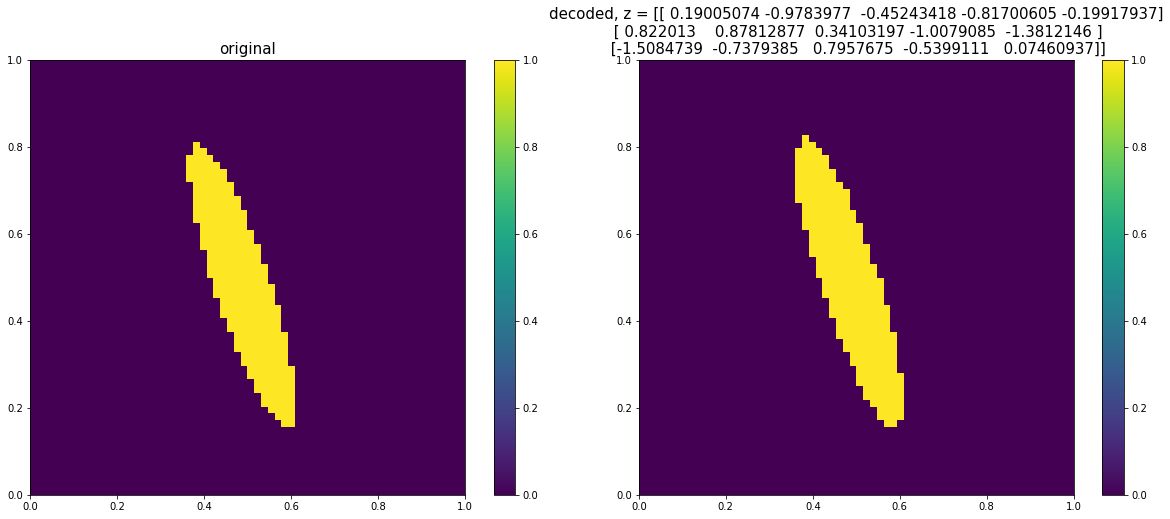

In [5]:
%%time
import io_functions as iof
importlib.reload(iof)

import plotting_functions as plf
importlib.reload(plf)

generator = iof.shapes_images_generator
dataset = tf.data.Dataset.from_generator(generator, output_signature=(tf.TensorSpec(shape=image_shape, dtype=tf.bool)))
dataset = dataset.batch(3)

tag = "0100_Jul_06_2021_09_15"
encoder, decoder = iof.loadEncoderDecoder(tag)
vae = VAE(encoder, decoder, 1.0)
vae.compile()

losses = []

for data in dataset.take(1000):
    
    if len(losses)<5:
        plf.plotOriginal_vs_decoded(data, vae, threshold=0.2)
        
    result = vae.evaluation(data=data, threshold = 0.2)
    data = tf.cast(data, dtype=tf.int32)
    mask_size = tf.math.reduce_sum(data)
    result["mask_size"] = mask_size.numpy()
    losses.append(result)
      
df_on_fake = pd.DataFrame(data=losses)

## Collect loss for the entire dataset and put into Pandas DataFrame for further analysis.
## Display example original and decoded images from ELITPC dataset

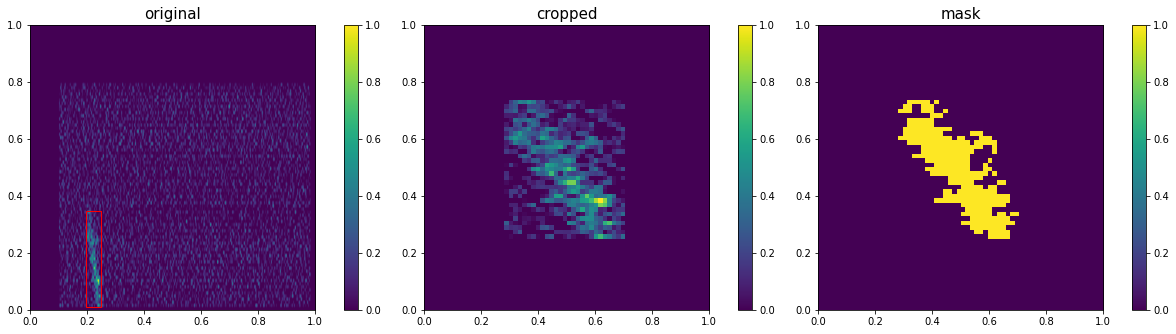

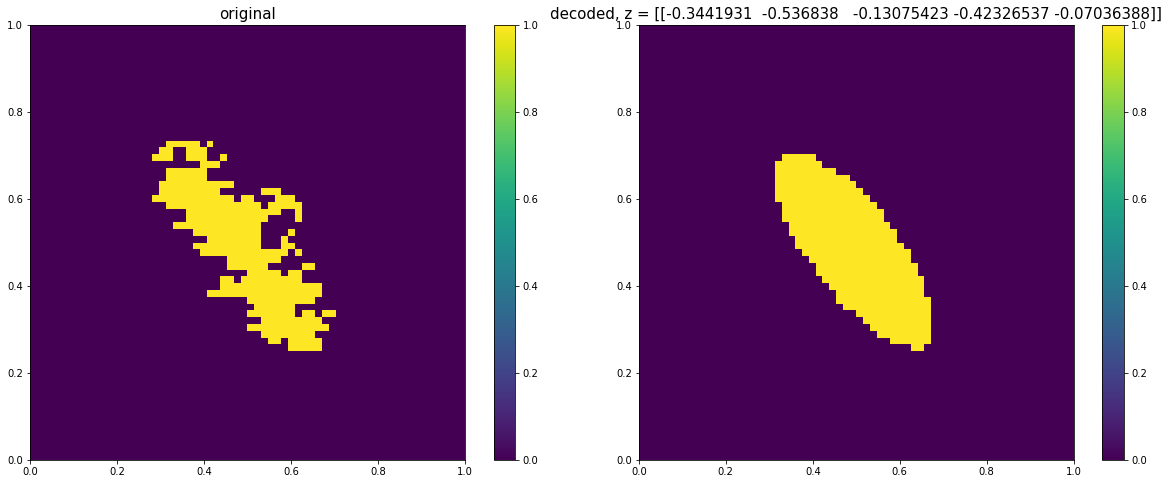

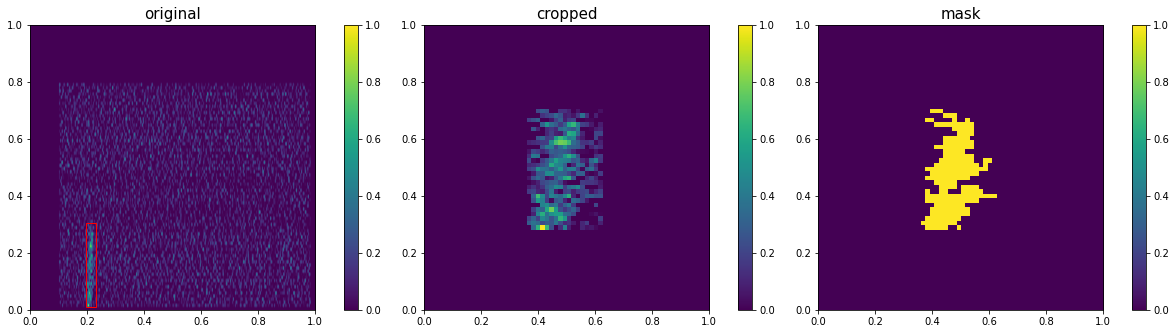

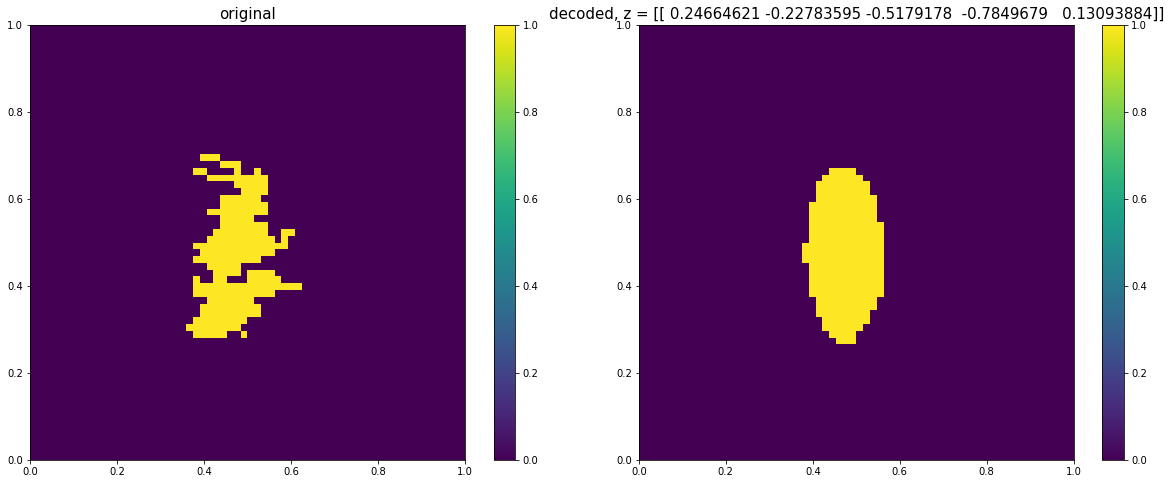

In [6]:
import io_functions as iof
importlib.reload(iof)

import plotting_functions as plf
importlib.reload(plf)

fileNames = ["UVWProjections_2018-06-19T15:13:33.941_0008.tfrecords"]
dataset = iof.readTFRecordFile(fileNames)
dataset = dataset.map(lambda item: iof.preprocessProjections(item, projection=0))

#tag = "0050_Jul_05_2021_12_29"
#encoder, decoder = iof.loadEncoderDecoder(tag)
#vae = VAE(encoder, decoder, 1.0)
#vae.compile()

losses = []
    
for data in dataset:

    rois = iof.find_ROIs(data, **params)
    if not len(rois):
        roi = None
    else:
        roi = rois[0]
    cropped, mask = iof.crop_ROI(data, roi, shape=(64,64))  
    mask_batched = tf.reshape(mask, (1,)+mask.shape)
    
    if len(losses)<2:
        plf.plotOriginal_vs_cropped(data, cropped, mask, roi)
        plf.plotOriginal_vs_decoded(mask_batched, vae, threshold = 0.2) 

    result = vae.evaluation(data=mask_batched, threshold = 0.2)
    mask_batched = tf.cast(mask_batched, dtype=tf.int32)
    mask_size = tf.math.reduce_sum(mask_batched)
    result["mask_size"] = mask_size.numpy()
    losses.append(result)
      
df = pd.DataFrame(data=losses)

'\n#t-SNE\nprint("Computing t-SNE embedding")\ntsne = manifold.TSNE(n_components=2, init=\'pca\', random_state=0)\nX_tsne = tsne.fit_transform(df1)\ndf3 = pd.DataFrame(data=X_tsne, columns = ["x","y"])\ndf3.plot.scatter(x="x",y="y")\n'

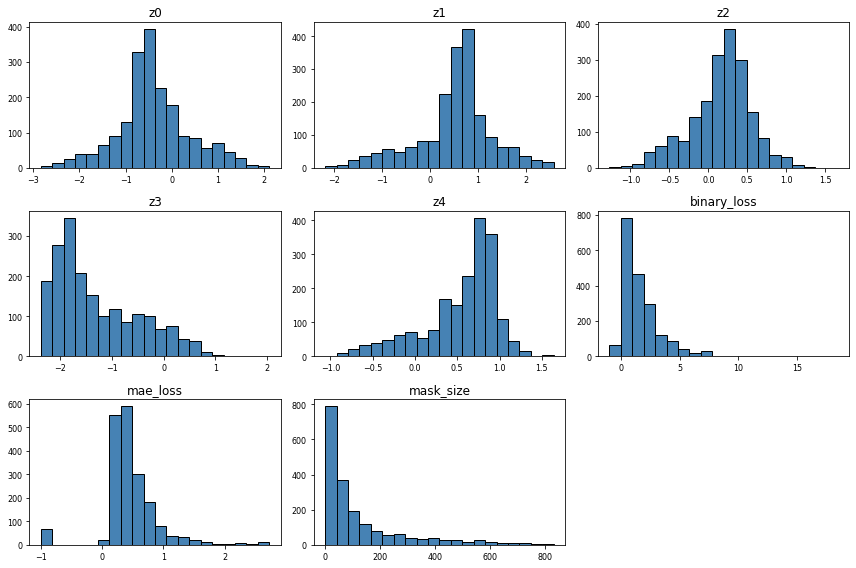

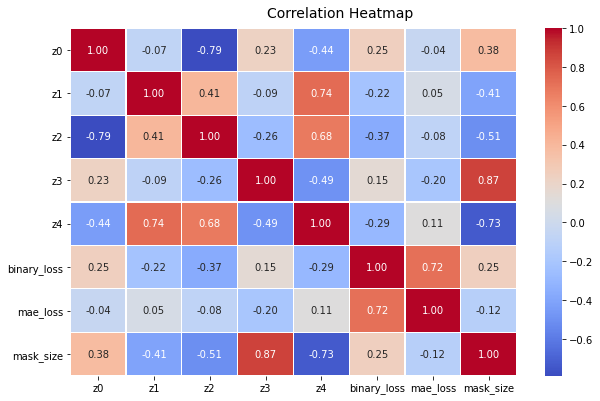

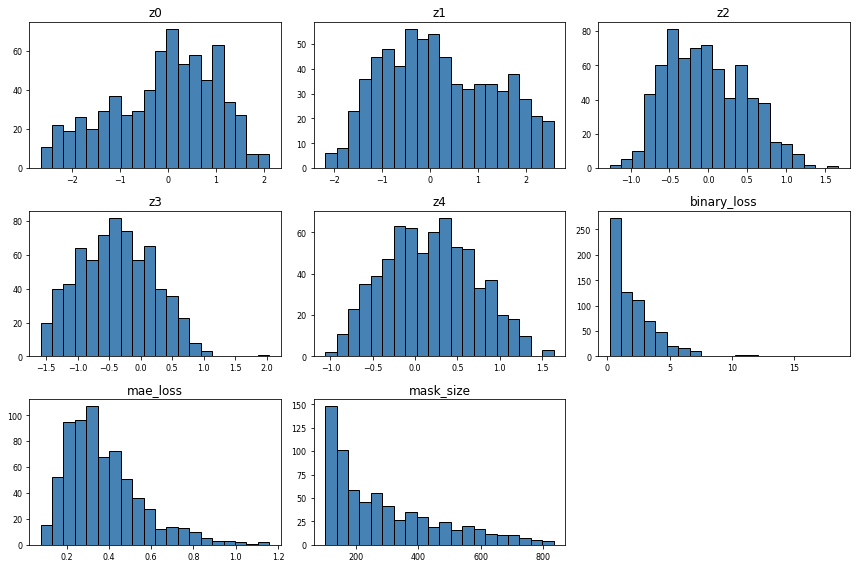

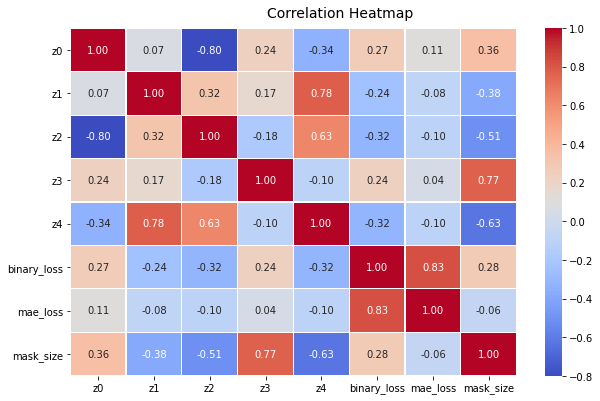

In [7]:
import plotting_functions as plf
importlib.reload(plf)

import io_functions as iof
importlib.reload(iof)

from sklearn import manifold
import plotly.express as px

#df = df_on_fake
plf.plot_latent_space(df)

df1 = df[df["mask_size"]>100]
plf.plot_latent_space(df1)
df1 = df.drop(["binary_loss", "mae_loss", "mask_size"], axis=1)

'''
#t-SNE
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(df1)
df3 = pd.DataFrame(data=X_tsne, columns = ["x","y"])
df3.plot.scatter(x="x",y="y")
'''

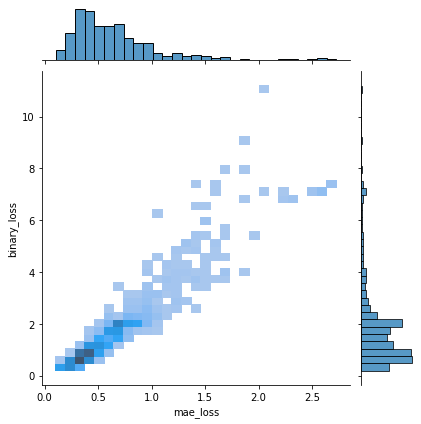

In [8]:
import seaborn as sns
df9 = df[(df["mask_size"]<50)&(df["mask_size"]>0)]
sns.jointplot(x="mae_loss", y="binary_loss", data=df9, kind='hist') 

In [9]:
fig = px.scatter(x=df2["x"], y=df2["y"])
fig.show()

NameError: name 'df2' is not defined

## Plot loss distribution and select outliers

In [ ]:
import plotting_functions as plf
importlib.reload(plf)

plf.plotLoss(df)
plf.plotLoss(df[df["mask_size"]>100])

df_anomalies = df[(df["mae_loss"]>0.75) & (df["mask_size"]>100)]

print("Number of all events:",df.shape[0])
print("Number of anomalies:",df_anomalies.shape[0])

## Plot selected anomalies

In [ ]:
import plotting_functions as plf
importlib.reload(plf)

import io_functions as iof
importlib.reload(iof)

events = df_anomalies.index[0:]               

fileNames = ["UVWProjections_2018-06-19T15:13:33.941_0008.tfrecords"]
dataset = iof.readTFRecordFile(fileNames)
dataset = dataset.map(lambda item: iof.preprocessProjections(item, projection=0))
dataset = dataset.enumerate()

#events = (636) #The three tracks event

for index, data in dataset:
    
    if not np.isin(index,events):
        continue
                  
    rois = iof.find_ROIs(data, **params)
    if not len(rois):
        roi = None
        continue
    else:
        roi = rois[0]
           
    cropped, mask = iof.crop_ROI(data, roi, shape=(64,64))
    batched_mask = tf.reshape(mask, (1,)+mask.shape)
    
    threshold = 0.2
    plf.plotOriginal_vs_cropped(data, cropped, mask, roi)
    plf.plotOriginal_vs_decoded(batched_mask, vae, threshold)
    loss = vae.evaluation(batched_mask, threshold)
    print("Event: {} loss: {} \n\tmask size: {}".format(index, loss, roi["size"]))

## TESTS

In [ ]:
import plotting_functions as plf
importlib.reload(plf)

import io_functions as iof
importlib.reload(iof)

from skimage.transform import probabilistic_hough_line
from skimage.morphology import skeletonize
from skimage.morphology import square
from skimage.morphology import (erosion, dilation, opening, closing,  # noqa
                                white_tophat)
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage import feature
from skimage import filters
import matplotlib.pyplot as plt

fileNames = ["UVWProjections_2018-06-19T15:13:33.941_0008.tfrecords"]
dataset = iof.readTFRecordFile(fileNames)
dataset = dataset.map(lambda item: iof.preprocessProjections(item, projection=0))
dataset = dataset.enumerate()

events = (636) #The three tracks event
#events = (4)

params = {
        'threshold_abs': 0.2, #seed pixel magnitude 
        'min_distance' : 0,   #minimal distance between roi seeds
        'roi_size_thr': 10    #minimal number of pixels in roi (patch)
        }

for index, data in dataset:
    
    if not np.isin(index,events):
        continue
        
    #####    
    image = np.reshape(data, (512,92)) + 0.002
    edges1 = feature.peak_local_max(image, min_distance=0, indices=False, threshold_abs=0.1)
    edges2 = feature.peak_local_max(image, min_distance=0, indices=False, threshold_abs=0.15)
    edges3 = feature.peak_local_max(image, min_distance=0, indices=False, threshold_abs=0.2)
    lines = probabilistic_hough_line(image, threshold=10, line_length=15, line_gap=30)
    # display results
    imageRange = [0,1, 0,1]  
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 8))

    ax[0].imshow(image, extent=imageRange)
    ax[0].set_title('noisy image', fontsize=20)

    ax[1].imshow(edges1, extent=imageRange)
    ax[1].set_title(r'Canny filter, $\sigma=1$', fontsize=20)
    
    #print(lines)
    for line in lines:
        p0, p1 = line
        #ax[1].plot((p0[0], p1[0]), (p0[1], p1[1]))

    ax[2].imshow(edges3, extent=imageRange)
    ax[2].set_title(r'Canny filter, $\sigma=3$', fontsize=20)
    
    edges3 = tf.cast(edges3, tf.float32)
    data = tf.reshape(edges3, image.shape+(1,))
    #continue
    #####
                  
    rois = iof.find_ROIs(data, **params)
    print("Number of rois:",len(rois))
    if not len(rois):
        roi = None
        continue
    else:
        roi = rois[0]
    cropped, mask = iof.crop_ROI(data, roi, shape=(64,64))
    batched_mask = tf.reshape(mask, (1,)+mask.shape)
      
    plf.plotOriginal_vs_cropped(data, cropped, mask, roi)
    plf.plotOriginal_vs_decoded(batched_mask, vae)
    loss = vae.evaluation(batched_mask)
    print("Event: {} loss: {}".format(index, loss))